* Name: Gonçalo Nuno Matos Gomes
* student number: 20211007

# Individual Project: Options Strategies

* Imagine you are an investor that has decided they are extremely risk adverse and wants to invest
in such a way as to remove as much risk as possible.
* In this assignment, you will construct a box spread using real-world market data, analyze the
potential returns, and critically evaluate the risk-return profile of this strategy. Your aim is to examine this strategy in detail.

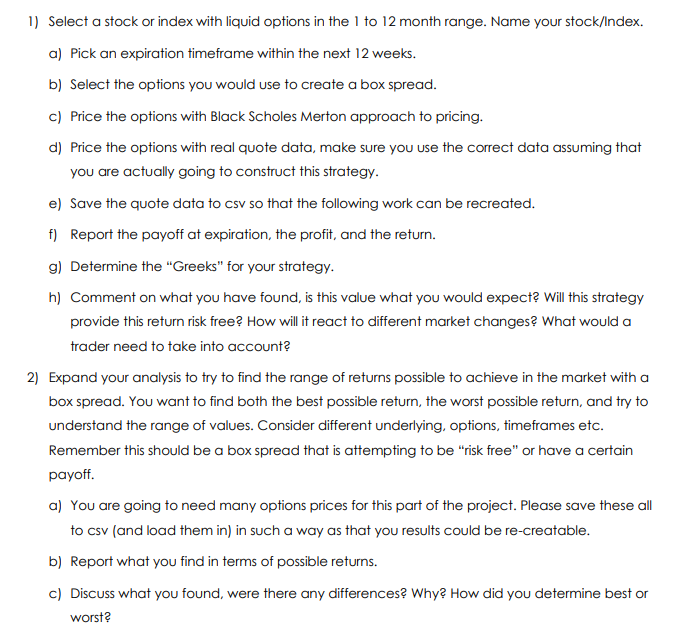

In [ ]:
import yfinance as yf
from datetime import datetime, timedelta
from scipy.stats import norm
import numpy as np
import pandas as pd

## 1.) Select a stock or index with liquid options in the 1 to 12 month range. Name your stock/Index.

I decided to to pick the S&P500 ETF (SPY) for the following reasons:
  * SPY is one of the most liquid ETFs in the world;
  * SPY options are available on a weekly and monthly basis, covering the 1-12 month range;
  * It has low implied volatility which makes box spreads more efficient and closer to risk-free;

In [ ]:
# Defining the ticker symbol
ticker = "SPY"

### a.) Pick an expiration timeframe within the next 12 weeks.

In [ ]:
# Downloading the option chain experations
spy = yf.Ticker(ticker)
expirations = spy.options

today = datetime.strptime("2025-03-31", '%Y-%m-%d')

# Filtering for expirations in the next 12 weeks
twelve_weeks = today + timedelta(weeks = 12)

# Filtering expiration dates within the next 12 weeks
valid_expirations = []
for exp in expirations:
  exp_date = datetime.strptime(exp, '%Y-%m-%d')
  if today < exp_date <= twelve_weeks:
    valid_expirations.append(exp)

print("Expirations within 12 weeks:", valid_expirations)

Expirations within 12 weeks: ['2025-04-07', '2025-04-08', '2025-04-09', '2025-04-10', '2025-04-11', '2025-04-17', '2025-04-25', '2025-04-30', '2025-05-02', '2025-05-09', '2025-05-16', '2025-05-30', '2025-06-20']


I am choosing April 11, 2025 as the expiration timeframe for the following reasons:
  * Since we are an extremelly risk-averse investor, a short-dated option structure aligns perfectly with my goal: capital preservation with a near-certian return;
  * SPY will likely have good liquidity in April because it's considered a good "monthly option";

### b.) Select the options you would use to create a box spread

In [ ]:
# Retrieving the real SPY price
spy = yf.Ticker("SPY")

#SPY Price (31-03-2025)
S = 550
print(f"Live SPY price: {S:.2f}")

# Dynamically selecting K1 and K2 around ATM price

# using a 5$ interval for SPY
strike_step = 5
atm_floor = np.floor(S / strike_step) * strike_step

# Defining the strike prices (k1 --> below ATM & k2 --> above ATM)
K1 = atm_floor - strike_step
K2 = atm_floor + strike_step
print(f"Selected strikes -> K1: {K1}, K2: {K2}")

# Selecting the expiration date defined earlier
expiration_date = "2025-04-11"

# Option chain for the dynamically selected strikes
option_chain = spy.option_chain(expiration_date)
calls = option_chain.calls
puts = option_chain.puts

call_options = calls[calls['strike'].isin([K1, K2])]
put_options = puts[puts['strike'].isin([K1, K2])]

# Displaying updated option
print("\nCALLS:")
print(call_options[['contractSymbol', 'strike', 'bid', 'ask']])

print("\nPUTS:")
print(put_options[['contractSymbol', 'strike', 'bid', 'ask']])

Live SPY price: 550.00
Selected strikes -> K1: 545.0, K2: 555.0

CALLS:
        contractSymbol  strike    bid    ask
41  SPY250411C00545000   545.0  12.64  12.68
51  SPY250411C00555000   555.0   6.85   6.88

PUTS:
        contractSymbol  strike    bid    ask
46  SPY250411P00545000   545.0   6.95   6.98
56  SPY250411P00555000   555.0  11.38  11.42


* These are the real bid/ask prices for the 495 and 505 strikes on calls and puts, that I will use to build the box spread.

### C.) Price the options with Black Scholes Merton approach to pricing.

Black-Scholes Model:

* The Black-Scholes-Merton (BSM) model, is a mathematical equation that estimates the theoretical value of derivatives based on other investment instruments, taking the impact of time and other risk factors into account.

Assumptions:

1. No dividends are paid out during the life of the option.
2. Markets are random because market movements can't be predicted.
3. There are no transaction costs in buying the option.
4. The risk-free rate and volatility of the underlying asset are known and constant.
5. The returns of the underlying asset are normally distributed.
6. The option is European and can only be exercised at expiration.


* Model Parameters:
  * S = SPY current price (we’ll pull it live)
  * K = Strike price (495 and 505 dollars)
  * T = Time to expiration (in years)
  * r = Risk-free rate (we’ll assume 4% = 0.04 for now)
  * σ = Implied volatility (IV) for each option (we will estimate using an assumption or grab live IV if needed)
  * Option type = Call or Put

In [ ]:
# Black-Scholes Model Formula

def black_scholes_merton(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return price

# Parameters

# SPY Price (31-03-2025)
S = 550
# Risk-free rate
r = 0.04
expiration_date = datetime.strptime("2025-04-11", "%Y-%m-%d")
today = datetime.today()
# Time to expiration in years
T = (expiration_date - today).days / 365

# Assuming ATM Implied Volatility
sigma = 0.18

# BSM pricing for each component
call_K1 = black_scholes_merton(S, K1, T, r, sigma, 'call')
call_K2 = black_scholes_merton(S, K2, T, r, sigma, 'call')
put_K1 = black_scholes_merton(S, K1, T, r, sigma, 'put')
put_K2 = black_scholes_merton(S, K2, T, r, sigma, 'put')

# Outputing BSM prices
print(f"BSM Prices:")
print(f"Call at {K1}$ = {call_K1:.2f}$")
print(f"Call at {K2}$ = {call_K2:.2f}$")
print(f"Put at {K1}$ = {put_K1:.2f}$")
print(f"Put at {K2}$ = {put_K2:.2f}$")

BSM Prices:
Call at 545.0$ = 9.68$
Call at 555.0$ = 4.60$
Put at 545.0$ = 4.08$
Put at 555.0$ = 8.99$


* For a call option, the BSM price is how much I should pay today to buy the right to purchase the stock at the strike price in the future.
* For a put option, it’s the fair value for the right to sell the stock at the strike price in the future.

### d.) Price the options with real quote data, make sure you use the correct data assuming that you are actually going to construct this strategy.


* Assuming that I am actually going to build the strategy, I need to identify the real-world cost of each option leg!

In [ ]:
# Parameters
ticker = "SPY"
expiration = "2025-04-11"
K1 = 545
K2 = 555

# Retrieving the option chain
spy = yf.Ticker(ticker)
calls = spy.option_chain(expiration).calls
puts = spy.option_chain(expiration).puts

# Getting relevant strikes
call_legs = calls[calls['strike'].isin([K1, K2])].set_index('strike')
put_legs = puts[puts['strike'].isin([K1, K2])].set_index('strike')

# Extracting the actual trading prices

# Buy Call at 545$
call_buy_price = call_legs.loc[K1]['ask']
# Sell Call at 555$
call_sell_price = call_legs.loc[K2]['bid']
# Buy Put at 555$
put_buy_price = put_legs.loc[K2]['ask']
# Sell Put at 545$
put_sell_price = put_legs.loc[K1]['bid']

# Print results
print("Real Market Prices")
print("------------------------------")
print(f"Buy Call at {K1}$: ${call_buy_price:.2f}$")
print(f"Sell Call at {K2}$: ${call_sell_price:.2f}$")
print(f"Buy Put at {K2}$: ${put_buy_price:.2f}$")
print(f"Sell Put at {K1}$: ${put_sell_price:.2f}$")
print("------------------------------")

Real Market Prices
------------------------------
Buy Call at 545$: $12.68$
Sell Call at 555$: $6.85$
Buy Put at 555$: $11.42$
Sell Put at 545$: $6.95$
------------------------------


* In summary, these four prices define the real-world entry cost into the box spread, meaning that it's actually what I would pay and receive if I opened the box spread in the market today, considering the stock price defined earlier.

### e.) Save the quote data to csv so that the following work can be recreated.


In [ ]:
# Building the quote data
quote_data = [
    {"Leg": "Buy Call", "Action": "Buy", "Option Type": "Call", "Strike": K1, "Price Used": call_legs.loc[K1]['ask'], "Source": "Ask"},
    {"Leg": "Sell Call", "Action": "Sell", "Option Type": "Call", "Strike": K2, "Price Used": call_legs.loc[K2]['bid'], "Source": "Bid"},
    {"Leg": "Buy Put", "Action": "Buy", "Option Type": "Put", "Strike": K2, "Price Used": put_legs.loc[K2]['ask'], "Source": "Ask"},
    {"Leg": "Sell Put", "Action": "Sell", "Option Type": "Put", "Strike": K1, "Price Used": put_legs.loc[K1]['bid'], "Source": "Bid"}
]

# Converting to a DataFrame
df_quotes = pd.DataFrame(quote_data)

# Saving and Displaying the DataFrame
# df_quotes.to_csv("/content/drive/MyDrive/Nova Ims/Financial Derivatives/box_spread_quotes.csv", index=False)
df_quotes

,Leg,Action,Option Type,Strike,Price Used,Source
0,Buy Call,Buy,Call,545,12.68,Ask
1,Sell Call,Sell,Call,555,6.85,Bid
2,Buy Put,Buy,Put,555,11.42,Ask
3,Sell Put,Sell,Put,545,6.95,Bid


### f.)  Report the payoff at expiration, the profit, and the return.

In [ ]:
K1 = 545
K2 = 555

df_quotes = pd.read_csv("/content/drive/MyDrive/Nova Ims/Financial Derivatives/box_spread_quotes.csv")

# Calculate the total cost of entering in this strategy
cost = 0
for _, row in df_quotes.iterrows():
    if row['Action'] == 'Buy':
        cost += row['Price Used']
    else:
        cost -= row['Price Used']

# Calculating the fixed payoff at expiration data (k2 - k1)
K1 = df_quotes[df_quotes['Strike'] == df_quotes['Strike'].min()]['Strike'].iloc[0]
K2 = df_quotes[df_quotes['Strike'] == df_quotes['Strike'].max()]['Strike'].iloc[0]
payoff = K2 - K1

# Calculating the profit and final return
profit = payoff - cost
ret = profit / cost

# Displaying the results
print(f"Total Cost of entering the Strategy: ${cost:.2f}")
print(f"Payoff at Expiration: ${payoff:.2f}")
print(f"Profit: ${profit:.2f}")
print(f"Return on Cost: {ret:.2%}")

Total Cost of entering the Strategy: $10.30
Payoff at Expiration: $10.00
Profit: $-0.30
Return on Cost: -2.91%


* With these results, I am basically paying more for the box-spread (10.30 dollars) that what I would receive at expiration (10 dollars);
* This result reflects the presence of bid-ask spreads, which in this case, are enough to eliminate theoretical arbitrage opportunities;
* Although the strategy is riskless in payoff structure, it is not free of cost and the return becomes negative due to execution costs;

### g.) Determine the “Greeks” for your strategy.

* In this section, I will calculate the "Greeks" which are a set of risk measures, which indicate how sensitive an option is to time-value decay, changes in implied volatility, and movements in the price of its underlying security.

1. Delta:
  * Delta is a measure of the change in an option's price or premium resulting from a change in the underlying asset;
2. Gamma:
  * Gamma measures the delta's rate of change over time, as well as the rate of change in the underlying asset, and helps forecast price moves in the underlying asset;
3. Vega:
  * Vega measures the risk of changes in implied volatility or the forward-looking expected volatility of the underlying asset
4. Theta:
  * Theta measures time decay in the value of an option or its premium;
5. Rho:
  * Rho measures the impact of changes in interest rates of an option's price;

--> In this task, I will aggregate the "Greeks" into a a net Greek exposure, representing the overall risk profile of the entire strategy.

With this box-spread, should be proved that:
  * Delta, Vega and Gamma are neutral;
  * Low or small Theta (limited time decay)
  * Small exposure to Rho because it behaves as a bond

In [ ]:
# Parameters

# SPY price (fixed)
S = 550.00

# Strike prices used in the box spread
K1 = 545
K2 = 555

# Time Decay
T = (datetime.strptime("2025-04-11", "%Y-%m-%d") - datetime.strptime("2025-03-31", "%Y-%m-%d")).days / 365

# Risk-free rate
r = 0.04

# Implied volatility
sigma = 0.18

# Greek Functions
def d1(S, K, T, r, sigma):
    return (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))

def d2(S, K, T, r, sigma):
    return d1(S, K, T, r, sigma) - sigma * np.sqrt(T)

def bs_greeks(S, K, T, r, sigma, option_type='call'):
    d_1 = d1(S, K, T, r, sigma)
    d_2 = d2(S, K, T, r, sigma)

    # Delta --> price sensitivity to underlying asset
    delta = norm.cdf(d_1) if option_type == 'call' else -norm.cdf(-d_1)

    # Gamma --> sensitivity of delta to underlying asset's price
    gamma = norm.pdf(d_1) / (S * sigma * np.sqrt(T))

    # Vega --> sensitivity to changes in volatility (percent change)
    vega = S * norm.pdf(d_1) * np.sqrt(T) / 100

    # Theta --> sensitivity to time decay (per day)
    theta = (
        - (S * norm.pdf(d_1) * sigma) / (2 * np.sqrt(T))
        - r * K * np.exp(-r * T) * norm.cdf(d_2 if option_type == 'call' else -d_2)
    ) / 365

    # Rho --> sensitivity to interest rate changes (per 1%)
    rho = (K * T * np.exp(-r * T) * norm.cdf(d_2 if option_type == 'call' else -d_2)) / 100

    return {'Delta': delta, 'Gamma': gamma, 'Vega': vega, 'Theta': theta, 'Rho': rho}

# Defining each option leg in the box-spread
legs = [
    {"type": "call", "strike": K1, "action": "Buy"},
    {"type": "call", "strike": K2, "action": "Sell"},
    {"type": "put",  "strike": K2, "action": "Buy"},
    {"type": "put",  "strike": K1, "action": "Sell"},
]

# Initializing the aggregated Greeks
total_greeks = {'Delta': 0, 'Gamma': 0, 'Vega': 0, 'Theta': 0, 'Rho': 0}
print("Individual Leg Greeks:\n")

# Itarating through the legs
for leg in legs:

    # Getting Greeks for this specific leg
    g = bs_greeks(S, leg['strike'], T, r, sigma, leg['type'])

    # If its a buy (+1); if its a sell (-1)
    multiplier = 1 if leg['action'] == 'Buy' else -1

    # Aggregating the Greeks into total strategy exposure
    for k in total_greeks:
        total_greeks[k] += multiplier * g[k]
    print(f"{leg['action']} {leg['type'].capitalize()} at {leg['strike']}$: {g}")

# Final Greeks values
print("\nNet Greeks for the Box Spread Strategy:")
for k, v in total_greeks.items():
    print(f"{k}: {v:.4f}")

Individual Leg Greeks:

Buy Call at 545$: {'Delta': np.float64(0.6355014244349659), 'Gamma': np.float64(0.021860486141372672), 'Vega': np.float64(0.3587215938184976), 'Theta': np.float64(-0.33070570635189056), 'Rho': np.float64(0.10231710637607958)}
Sell Call at 555$: {'Delta': np.float64(0.40694474107802336), 'Gamma': np.float64(0.022578286849321543), 'Vega': np.float64(0.3705004084493463), 'Theta': np.float64(-0.32712425451792887), 'Rho': np.float64(0.0659657809132754)}
Buy Put at 555$: {'Delta': np.float64(-0.5930552589219766), 'Gamma': np.float64(0.022578286849321543), 'Vega': np.float64(0.3705004084493463), 'Theta': np.float64(-0.3398977835373891), 'Rho': np.float64(0.10109298571679098)}
Sell Put at 545$: {'Delta': np.float64(-0.364498575565034), 'Gamma': np.float64(0.021860486141372672), 'Vega': np.float64(0.3587215938184976), 'Theta': np.float64(-0.3159473376285083), 'Rho': np.float64(0.06173159238677841)}

Net Greeks for the Box Spread Strategy:
Delta: -0.0000
Gamma: 0.0000
Veg

From the Results, we can conclude the following:

--> The "Greeks" computed are Delta, Gamma and Vega neutral, as expected. This also shows that the constructed box-spread behaves independently of the asset's volatility.

--> The negative Theta shows a small time decay, which comes from the fact that I am using a short-term option near expiration.

--> The strategy shows a positive Rho, consistentwith the idea that: as interest rates rise, the present value of the future payoff decreases.

--> Overall, these measures confirm that the box-spread is directionless and low-risk!

### h.) Comment on what you have found, is this value what you would expect? Will this strategy provide this return risk free? How will it react to different market changes? What would a trader need to take into account?


Yes, the results allign with my previous expectations. In theory, the box-spread should generate a risk-free profit, because it garantees a known payoff at expiration (k2-k2). However, due to market ineficiencies and execution costs, the actual cost of entering the trade exceeds the final payoff.
In my case, the cost of entering the box-spread was 10.30 dollars and the garanteed payoff was 10$, which leads to a loss of about 0.30 dollars.
Basically, while the payoff is risk-free, the return is not due to trading costs.

In terms of the reaction to different market changes, the box-spread payoff is delta-hedged, which means that the payoff does not depend on where SPY closes. Regarding the time-decay, the strategy may lose a few cents, specially if held to close to maturity.
When it comes to volatility, it has no influence because I am holding both put and call options symmetrically, which makes this strategy vega-neutral. Also, the box-spread should remain stable across different price changes due to Gamma=0.

When it comes to the trader's behaviour, he should manage the execution costs as much as possible. Also, if the position is large, he may fail to fill all legs at optimal prices. Therefore, he should use limit orders, for example, in oder to reduce execution risk.
Furthermore, he has to be cautious regarding the liquidity of the asset, because with less liquid assets, the spread would widen and returns would worsen.
To finalize, he should also be attentive to interest rates, because the probability of the box-spread is connected to the risk-free rate. Therefore, is the rates are high, the payoff today would be even more discounted.

### 2.)  Expand your analysis to try to find the range of returns possible to achieve in the market with a box spread. You want to find both the best possible return, the worst possible return, and try to understand the range of values. Consider different underlying, options timeframes etc. Remember this should be a box spread that is attempting to be “risk free” have a certain payoff.

In [ ]:
# Parameters

# Setting S&P500 ETF for the box-spread
ticker = "SPY"

# Selecting "today's" date for reproducibility
today = datetime(2025, 4, 4)

# At the moment of the analysis, the price was 510$
atm_price = 510

# List of different strike widths to test
strike_widths = [10, 20, 30, 40]

# Considering maturities for the next 12 weeks
max_weeks = 12

spy = yf.Ticker(ticker)

# Extracting all the available maturities
all_expirations = spy.options
twelve_weeks_later = today + timedelta(weeks=max_weeks)

# Getting valid maturity dates
valid_expirations = [
    exp for exp in all_expirations
    if datetime.strptime(exp, "%Y-%m-%d") <= twelve_weeks_later
]

# initilizaing a list to store all spread configurations and outcomes
all_configs = []

# Iterating over maturities and strike widths
for expiration in valid_expirations:
    try:
        # Getting the option chain for this maturity
        option_chain = spy.option_chain(expiration)
        calls = option_chain.calls
        puts = option_chain.puts

        # Finding the common strikes available in both call and put options
        strikes = sorted(list(set(calls['strike']).intersection(set(puts['strike']))))

        # Picking symmetrical strikes around current price
        for width in strike_widths:
            K1 = atm_price - (width / 2)
            K2 = atm_price + (width / 2)

            # Making sure both strikes exist
            if K1 not in strikes or K2 not in strikes:
                continue

            try:
                # Building the box-spread
                call_buy = calls[calls['strike'] == K1]['ask'].values[0]
                call_sell = calls[calls['strike'] == K2]['bid'].values[0]
                put_buy = puts[puts['strike'] == K2]['ask'].values[0]
                put_sell = puts[puts['strike'] == K1]['bid'].values[0]

                # Calculate cost, payoff, profit and return
                cost = call_buy + put_buy - call_sell - put_sell
                payoff = K2 - K1
                profit = payoff - cost
                ret = profit / cost if cost != 0 else 0

                # Storing the obtained results
                all_configs.append({
                    'Expiration': expiration,
                    'K1': K1,
                    'K2': K2,
                    'Width': width,
                    'Call Buy (Ask)': call_buy,
                    'Call Sell (Bid)': call_sell,
                    'Put Buy (Ask)': put_buy,
                    'Put Sell (Bid)': put_sell,
                    'Cost': cost,
                    'Payoff': payoff,
                    'Profit': profit,
                    'Return': ret
                })

            except Exception as e:
                # Debugging step
                print(f"Error on {expiration}, K1={K1}, K2={K2}: {e}")

    except Exception as e:
        # Second Debugging step
        print(f"Error retrieving data for {expiration}: {e}")

# Convert to DataFrame
df_all_configs = pd.DataFrame(all_configs)

# Saving the DataFrame
# df_all_configs.to_csv("/content/drive/MyDrive/Nova Ims/Financial Derivatives/box_spread_analysis.csv", index=False)

In [ ]:
df_all_configs = pd.read_csv("/content/drive/MyDrive/Nova Ims/Financial Derivatives/box_spread_analysis.csv")

df_all_configs.head()

,Expiration,K1,K2,Width,Call Buy (Ask),Call Sell (Bid),Put Buy (Ask),Put Sell (Bid),Cost,Payoff,Profit,Return
0,2025-04-04,505.0,515.0,10,7.91,1.75,4.85,0.78,10.23,10.0,-0.23,-0.022483
1,2025-04-04,500.0,520.0,20,12.81,0.67,8.73,0.31,20.56,20.0,-0.56,-0.027237
2,2025-04-04,495.0,525.0,30,17.11,0.24,12.72,0.12,29.47,30.0,0.53,0.017984
3,2025-04-04,490.0,530.0,40,23.24,0.10,18.14,0.06,41.22,40.0,-1.22,-0.029597
4,2025-04-08,500.0,520.0,20,17.71,5.61,13.55,5.21,20.44,20.0,-0.44,-0.021526


### b.) Report what you find in terms of possible returns.

In [ ]:
# Displaying the entire DataFrame

df_all_configs

,Expiration,K1,K2,Width,Call Buy (Ask),Call Sell (Bid),Put Buy (Ask),Put Sell (Bid),Cost,Payoff,Profit,Return
0,2025-04-04,505.0,515.0,10,7.91,1.75,4.85,0.78,10.23,10.0,-0.23,-0.022483
1,2025-04-04,500.0,520.0,20,12.81,0.67,8.73,0.31,20.56,20.0,-0.56,-0.027237
2,2025-04-04,495.0,525.0,30,17.11,0.24,12.72,0.12,29.47,30.0,0.53,0.017984
3,2025-04-04,490.0,530.0,40,23.24,0.10,18.14,0.06,41.22,40.0,-1.22,-0.029597
4,2025-04-08,500.0,520.0,20,17.71,5.61,13.55,5.21,20.44,20.0,-0.44,-0.021526
5,2025-04-11,505.0,515.0,10,18.56,12.09,14.60,10.47,10.60,10.0,-0.60,-0.056604
6,2025-04-11,500.0,520.0,20,21.84,9.36,16.87,8.92,20.43,20.0,-0.43,-0.021047
7,2025-04-11,495.0,525.0,30,25.37,7.08,19.82,7.70,30.41,30.0,-0.41,-0.013482
8,2025-04-11,490.0,530.0,40,29.31,5.20,22.59,6.41,40.29,40.0,-0.29,-0.007198
9,2025-04-17,505.0,515.0,10,21.37,14.96,17.14,12.91,10.64,10.0,-0.64,-0.060150


In this analysis, I am using 39 valid box-spread configurations, each one consisting of:
* Different maturities;
* A symmetric strike pair (K1, K2) around a fixed ATM of 510 dollars;
* Varying strike widths (10, 20, 30, 40);

In [ ]:
# Building a table for the Summary of the reults

summary_table = pd.DataFrame({
    "Metric": [
        "Total Configurations",
        "Minimum Return (%)",
        "Maximum Return (%)",
        "Mean Return (%)",
        "Median Return (%)",
        "Positive Return Count",
        "Negative Return Count",
        "Zero Return Count"
    ],
    "Value": [
        39,
        f"{df_all_configs['Return'].min() * 100:.2f}%",
        f"{df_all_configs['Return'].max() * 100:.2f}%",
        f"{df_all_configs['Return'].mean() * 100:.2f}%",
        f"{df_all_configs['Return'].median() * 100:.2f}%",
        (df_all_configs["Return"] > 0).sum(),
        (df_all_configs["Return"] < 0).sum(),
        (df_all_configs["Return"] == 0).sum()
    ]
})

summary_table

,Metric,Value
0,Total Configurations,39
1,Minimum Return (%),-10.15%
2,Maximum Return (%),1.80%
3,Mean Return (%),-2.52%
4,Median Return (%),-2.25%
5,Positive Return Count,2
6,Negative Return Count,37
7,Zero Return Count,0


--> As we can see, returns are almost entirely negative, due to bid/ask spreads, liquidity costs and non-arbitrage pricing in SPY options. Only two spreads achieved a positive return.

In [ ]:
# Analyxing the best performing box-spread

best_return = df_all_configs.loc[df_all_configs["Return"].idxmax()]

best_spread_table = best_return.to_frame().reset_index()
best_spread_table.columns = ['Attribute', 'Best Spread']

best_spread_table

,Attribute,Best Spread
0,Expiration,2025-04-04
1,K1,495.0
2,K2,525.0
3,Width,30
4,Call Buy (Ask),17.11
5,Call Sell (Bid),0.24
6,Put Buy (Ask),12.72
7,Put Sell (Bid),0.12
8,Cost,29.47
9,Payoff,30.0


This was the best performing box-spread configuration due to the following possible reasons:

* I paid relatively little premium to buy my long call and long put and I received a decent bid on the short leg of the box-spread;
* Also, the maturity is really close which reduces the time premium;
* The fact that I had a large strike width (30), was good to smoothen the inneficiencies acroos the legs;

In [ ]:
# Analyzing the worst performing box-spread

worst_return = df_all_configs.loc[df_all_configs["Return"].idxmin()]

worst_spread_table = worst_return.to_frame().reset_index()
worst_spread_table.columns = ['Attribute', 'Worst Spread']

worst_spread_table

,Attribute,Worst Spread
0,Expiration,2025-05-30
1,K1,505.0
2,K2,515.0
3,Width,10
4,Call Buy (Ask),30.79
5,Call Sell (Bid),23.89
6,Put Buy (Ask),23.95
7,Put Sell (Bid),19.72
8,Cost,11.13
9,Payoff,10.0


This was the worst performing box-spread configuration due to the following possible reasons:

* I had extremelly high bid/ask spreads (Call Buy K1 = 30.79 and Put Buy K2 = 23.95);
* Also, the maturity date was much far away (30th May), which requires more time premium to buy long legs;
* I also had a narrow width for the strike (10), which can make any innificiency in princing eat more of the relative return;

--> In Summary, while box-spreads aim to be "risk-free" in theory, real-world execution costs often result in small losses. Positive returns are rare and usually reflect temporary market inneficiences.

### c.) Discuss what you found, were there any differences? Why? How did you determine best or worst?

* Yes, I think there are real differences between the retuns across the different box-spreads that I created.
While most returns are slightly negative (between -1% and -3%), a few showed larger losses and two rare cases resulted in positive returns.

* I also think that these differences occured due to several market and structural factors like, for example, the strike width, the expiration date, the net cost friction between bid and ask prices and also some market inneficiencies like temporarily misaliigned quotes.

* In Regards to the determination of best/worst box-spreads configuration, they were ranked by return. The best spread had a K1 = 495 and K2 = 525,with a +1.80% return. While the worst one had a K1 = 505 and K2 = 515, with a return of -10.15%